In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

seed=42

from fastai.vision import *
from fastai.callbacks.hooks import *
import scipy.ndimage

import gc

np.random.seed(seed)

In [2]:
from gradcam import *

In [3]:
def get_learner(data,is_fp16=False):
    gc.collect()
    learn = create_cnn(data, models.resnet50, metrics=accuracy)
    if is_fp16:
        learn = learn.to_fp16()
    return learn

In [27]:
import fastai.version
print(fastai.__version__)
print(torch.__version__)

1.0.55
1.1.0.dev20190418


# Final model

In [4]:
PATH = Path('data_draw')

In [5]:
data=None
gc.collect()

tfms = get_transforms()
data= ImageDataBunch.from_folder(PATH,train='train',valid='valid',test='both',bs=60,
                                 ds_tfms = tfms,size=350,num_workers=4).normalize(imagenet_stats)

learn= get_learner(data)
learn.load('stage1-350-new-8epochs-303');

/home/quantran/anaconda3/envs/python37/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


# From single Image object

In [6]:
test_img = PATH/'both/poca-mulan.jpg'
img = open_image(test_img);

In [11]:
type(learn)

fastai.basic_train.Learner

In [7]:
type(img)

fastai.vision.image.Image

CPU times: user 1.49 s, sys: 776 ms, total: 2.27 s
Wall time: 2.77 s


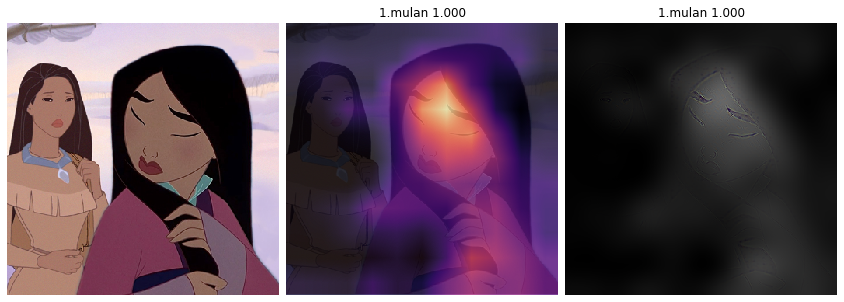

In [8]:
%%time
gcam = GradCam.from_one_img(learn,img)
gcam.plot()

You can generate heatmap according to any class label with label1 parameter (and additionaly heatmap with label2). This will be handy for studying your model. By default, label1 is the class label with highest probability given by your model

CPU times: user 326 ms, sys: 149 ms, total: 474 ms
Wall time: 120 ms


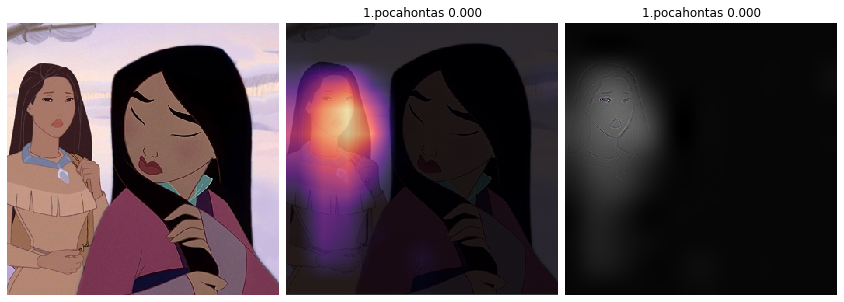

In [9]:
%%time
gcam = GradCam.from_one_img(learn,img,label1='pocahontas')
gcam.plot(plot_hm=True,plot_gbp=True)

## Plot 2 labels side-by-side (for model evaluation on different classes)

You can also choose to plot only heatmap or only guided backprop map

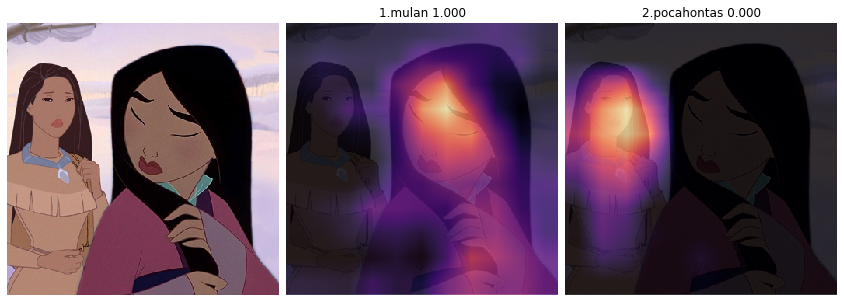

In [10]:
gcam = GradCam.from_one_img(learn,img,label2='pocahontas')
gcam.plot(plot_hm=True,plot_gbp=False)

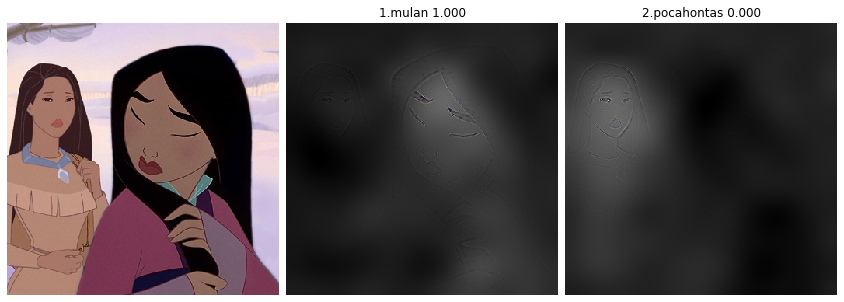

In [11]:
gcam = GradCam.from_one_img(learn,img,label2='pocahontas')
gcam.plot(plot_hm=False,plot_gbp=True)

# From classification interpretation (validation set)

In [12]:
interp = ClassificationInterpretation.from_learner(learn,ds_type = DatasetType.Valid)

In [14]:
accuracy(interp.preds,torch.tensor(data.valid_ds.y.items))

tensor(0.9421)

In [15]:
interp.most_confused(min_val=2)

[('castle', 'kiki', 8),
 ('beauty', 'tarzan', 6),
 ('hercules', 'mulan', 6),
 ('mulan', 'beauty', 6),
 ('beauty', 'mermaid', 4),
 ('hercules', 'beauty', 4),
 ('howl', 'tarzan', 4),
 ('beauty', 'hercules', 3),
 ('mermaid', 'tarzan', 3),
 ('beauty', 'kiki', 2),
 ('hercules', 'mermaid', 2),
 ('howl', 'kiki', 2),
 ('howl', 'mononoke', 2),
 ('kiki', 'mermaid', 2),
 ('mononoke', 'castle', 2),
 ('mononoke', 'kiki', 2),
 ('mulan', 'pocahontas', 2),
 ('pocahontas', 'howl', 2),
 ('pocahontas', 'mulan', 2),
 ('pocahontas', 'tarzan', 2),
 ('tarzan', 'beauty', 2),
 ('tarzan', 'mermaid', 2)]

## Investigate top confused classes, e.g castle vs kiki

In [16]:
def class2idx(clas):
    return data.classes.index(clas)
classes = data.classes
true_idx,pred_idx = class2idx('castle'),class2idx('kiki')
mismatch_idxs =[i for i,(tru,pred) in enumerate(zip(data.valid_ds.y.items,interp.pred_class.numpy())) if tru==true_idx and pred==pred_idx]
len(mismatch_idxs)

8

Notation: Gradcam -> GC, Guided Backprop -> GBP

Images from left to right:

**original image / GC w.r.t predicted label/ GBP w.r.t predicted label / GC w.r.t actual label / GBP w.r.t actual label)**

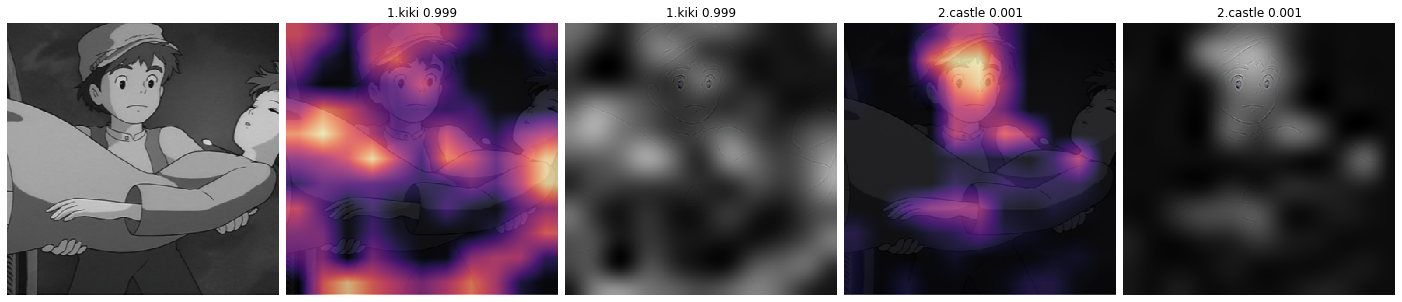

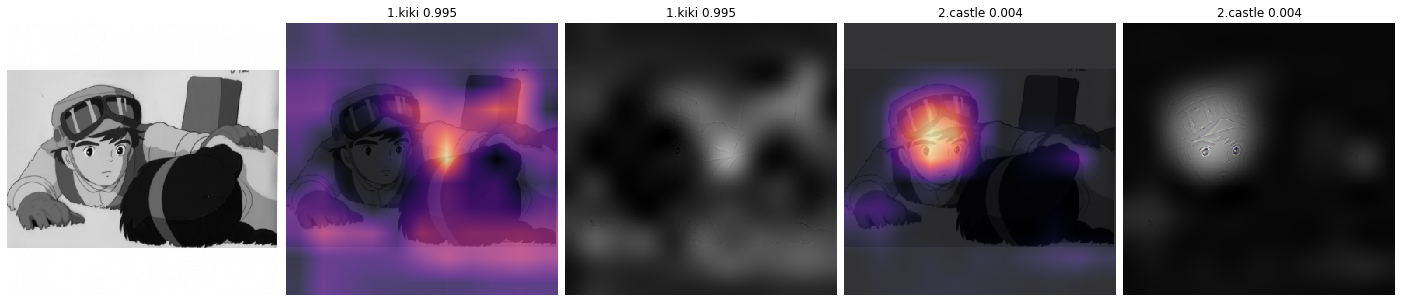

In [17]:
for idx in mismatch_idxs[:2]:
    gcam = GradCam.from_interp(learn,interp,idx,include_label=True)
    gcam.plot()

## Only plot predicted label

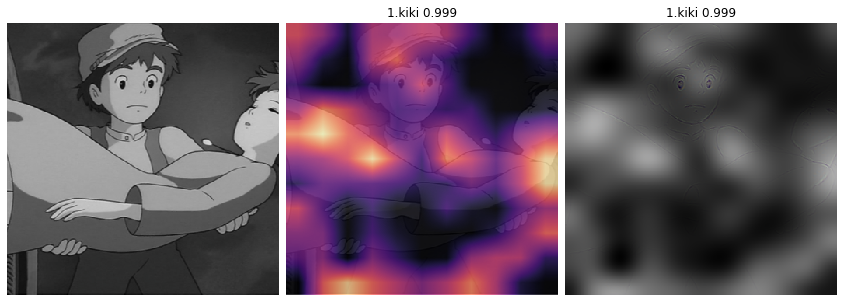

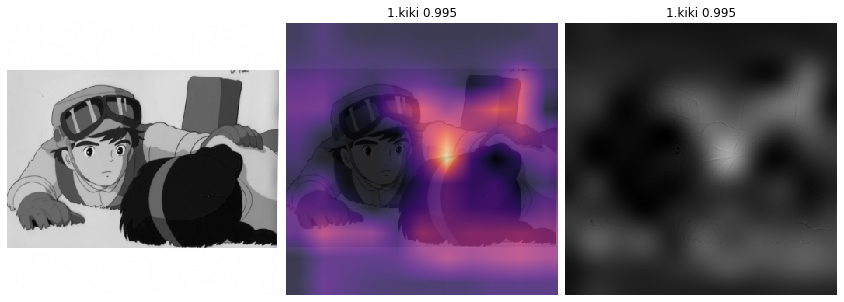

In [18]:
for idx in mismatch_idxs[:2]:
    gcam = GradCam.from_interp(learn,interp,idx,include_label=False)
    gcam.plot()

## From classification interpretation (Test set)

In [20]:
interp = ClassificationInterpretation.from_learner(learn,ds_type = DatasetType.Test)

interp.preds.shape

torch.Size([2, 10])

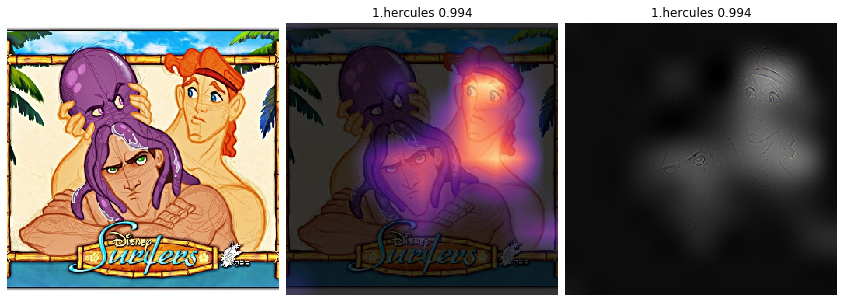

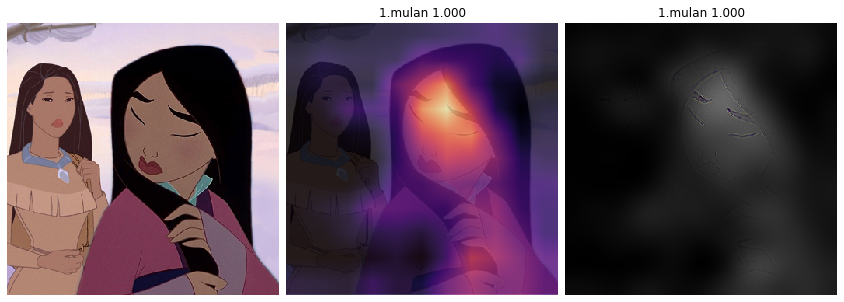

In [21]:
for idx in range(2):
    gcam = GradCam.from_interp(learn,interp,idx,ds_type = DatasetType.Test)
    gcam.plot()